# Grover Search Algorithm Implementation with Qiskit

## 1: The Problem
Grovers Search Algorithm, also known as quantum search algorithm is an algorithm that provides a quadratic speedup in comparison to classical computing. The problem it handles is the search of a value within an unstructured database. If the database is instead sorted, there are much more efficient algorithms that are already solved with classical computation. The unstructured feature is the key aspect of this solution that allows quantum circuits to surpass classical. 

**Classical Solution:** Linear search is our main method of searching with classical computation in an unstructured set. The runtime/time complexity is $O(n)$, meaning that the worst case scenario will lead to a search through the entirety of the dataset. 

**Quantum Solution (Grover Search Algorithm):** Grovers Search Algorithm offers a solution at $O(\sqrt n)$ time complexity. At scale this solution offers a quadratic speedup compared to our best solution with classical computers. 

We have a set of indices $\{0, 1, 2, 3, ...\}$ where the function $f(x) : \{0, 1\}^{⊗n} →\{0,1\}$. f(x) = 1 if x is the solution, if x is not the solution, f(x) = 0. The input can be the of a value or an encoded version of the output.

Oracle: flips the sign of the target value
Reflection Operator: rotates the amplitudes around the mean, there by raising the probability of the correct answer, and lowering the probabilities of the other answers. 
With this algorithm, you will loop over these gates in pairs for a predetermined number of iterations to give you the most optimal state to find your solution.

In [7]:
# import standard libraries
import qiskit
from qiskit.visualization import plot_bloch_multivector 
import numpy as np
import pylatexenc 
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator

## 2: Classical Circuit Implementation

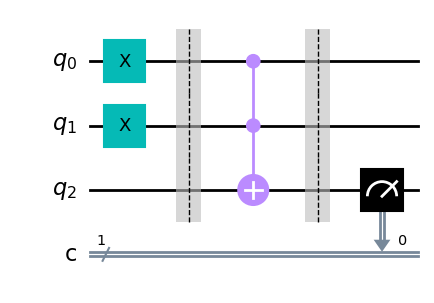

In [8]:
# n = number of bits
n = 3
# N = number of potential values
N = 2**(n-1)

# instantiate circuit
classical = QuantumCircuit(n, 1)

# set circuit input to "11"
classical.x([0,1])

# create validation
classical.barrier()
classical.ccx(0, 1, 2)
classical.barrier()

# measure results
classical.measure(n-1, 0)

display(classical.draw('mpl'))

We are given a 2 bit input where our job is to give the oracle an input that outputs the value 1, signifying that it is the correct input. In the worst case scenario, I'm going to start at 00, then 01, 10, until I reach the correct value 11. In this case I have to go through all of the possibilities to find the correct value that will return 1. For the sake of proving that it outputs 1 on the correct value, we will set this circuit to the correct value.

The Toffoli Gate featured above is similar to the AND gate in a classical circuit. If both the control qubits have the value 1, it will flip the value of the target qubit which is initially set to $|0\rangle$. So if both qubits have the value 1, "11", the function will output 1 as a result.

*Note: Notice where the measurements are in this circuit and where it the measurements take place in the coming implementations. Classical solutions have the patterns of always looking at the output of the function while quantum solutions tend to look at the quantum interference that effects the input values.*

{'1': 1024}


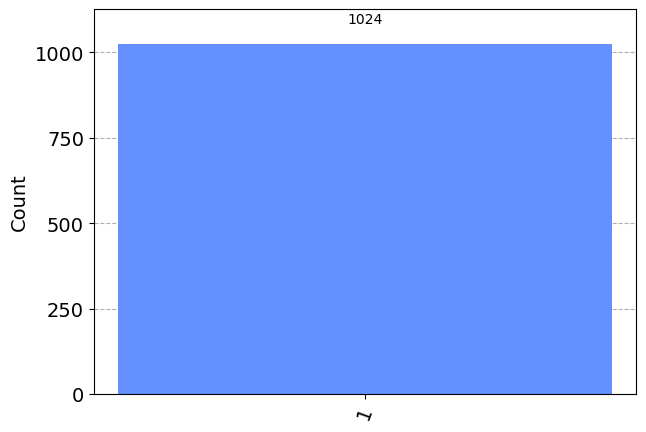

In [9]:
# simulate outputs
sim = AerSimulator()
compiled = transpile(classical, sim)
job = assemble(compiled)

result = sim.run(compiled).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

We can see here that we finally stumbled into our correct answer on our last attempt which outputted the value 1. Lets look at how we can do this more efficiently with a quantum circuit. 

## 3.1: Quantum Circuit Implementation (2 Qubit Example)
Continuing our previous 2 qubit example as a quantum circuit, we can see a few notable changes. First, there is now an additional measurement, the measurements are now taken from the 2 inputs rather than the output of the function, and we aren't using the 3rd qubit in this algorithm. This is not always the case since larger quantum circuit examples of this algorithm, would be using an output qubit and also additional auxilary qubits, but in this case we do not need it so this will remain empty. 

We see that there is 1 iteration of the Grover search algorithm since there is 1 oracle gate and 1 diffusion gate. As we had mentioned earlier, the overall purpose of the oracle is to flip the sign of the correct state we are looking for, while the diffusion operator reflects all amplitudes across the mean. 

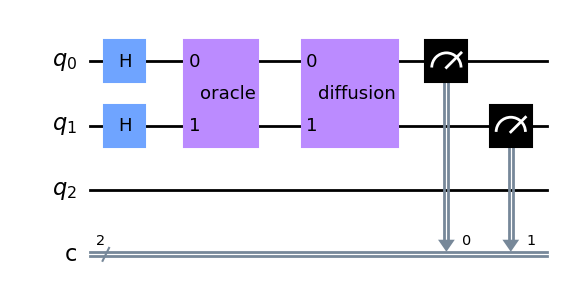

In [10]:
iter = 1

oracle = QuantumCircuit(n-1, name='oracle')
oracle.cz(0, 1)
oracle.to_gate()

diffusion = QuantumCircuit(n-1, name='diffusion')
diffusion.h(range(n-1))
diffusion.z(range(n-1))
diffusion.cz(0,1)
diffusion.h(range(n-1))
diffusion.to_gate()

grover = QuantumCircuit(n, n-1)
grover.h(range(n-1))
for i in range(iter):
    grover.append(oracle, range(n-1))
    grover.append(diffusion, range(n-1))
grover.measure(range(n-1), range(n-1))

display(grover.draw('mpl'))

{'11': 1024}


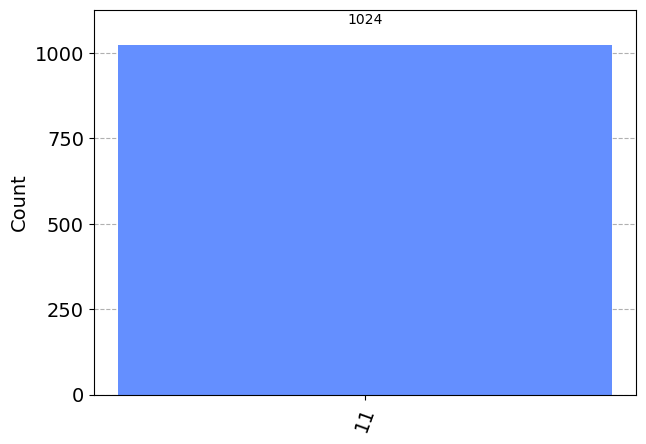

In [11]:
# simulate outputs
sim = AerSimulator()
compiled = transpile(grover, sim)
job = assemble(compiled)

result = sim.run(compiled).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

Our algorithm immediately outputs the correct answer with 100% accuracy. It increased the probability of the correct answer to 100% while it lowered all other options to 0. This is not realistic, as actual quantum computers would have noise effecting this result, but in the simulation, you theoretically should have a perfect output here after only 1 iteration. 

Lets take a closer look at what's going on inside the oracle and diffusion gates by unveiling the internals workings.

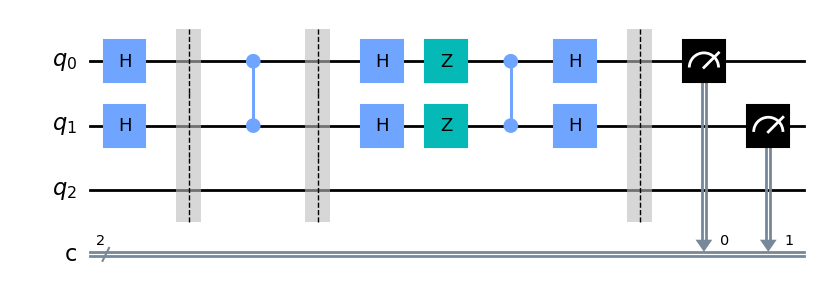

In [12]:
grover = QuantumCircuit(n, n-1)
grover.h(range(n-1))
grover.barrier()
grover.cz(0,1)
grover.barrier()
grover.h(range(n-1))
grover.z(range(n-1))
grover.cz(0,1)
grover.h(range(n-1))
grover.barrier()
grover.measure(range(n-1), range(n-1))

display(grover.draw('mpl'))

We can walk through the quantum states at each step of this circuit. I will also place the state vectors below each segment. Keep in mind that is representing $[ |00\rangle, |01\rangle, |10\rangle, |11\rangle ]$.

1. **After Hadamard gates on qubits both qubits (Barrier 1):**  
   $$ | \psi_1 \rangle = \frac{1}{\sqrt{2^{n-1}}} \sum_{x=0}^{2^{n-1}-1} |x\rangle $$
   $$[ 0.5+0j, 0.5+0j, 0.5+0j, 0.5+0j ]$$  

2. **After controlled-Z gate between both qubits (Barrier 2):**
   $$ | \psi_2 \rangle = \frac{1}{\sqrt{2^{n-1}}} \sum_{x=0}^{2^{n-1}-1} (-1)^{x_0 \cdot x_1} |x\rangle $$
   $$[ 0.5+0j, 0.5+0j, 0.5+0j, -0.5+0j ]$$
   
3. **After Hadamard gates on both qubits:**
*If you toy around with this you will notice that this hadamard is not necessary for our current case, but it is standard for our diffusion operator, so we will keep this here.*
   $$ | \psi_3 \rangle = \frac{1}{\sqrt{2^{n}}} \sum_{x=0}^{2^{n-1}-1} (-1)^{x_0 \cdot x_1} |x\rangle $$
   $$[ 0.5+0j, 0.5+0j, 0.5+0j, -0.5+0j ]$$

4. **After Z gates on both qubits:**
   $$ | \psi_4 \rangle = \frac{1}{\sqrt{2^{n}}} \sum_{x=0}^{2^{n-1}-1} (-1)^{x_0 \cdot x_1} |x\rangle $$
   $$[ 0.5+0j, -0.5+0j, -0.5+0j, -0.5+0j ]$$

5. **After controlled-Z gate between qubits 0 and 1:**
   $$ | \psi_5 \rangle = \frac{1}{\sqrt{2^{n}}} \sum_{x=0}^{2^{n-1}-1} (-1)^{x_0 \cdot x_1} |x\rangle $$
   $$[ 0.5+0j, -0.5+0j, -0.5+0j, 0.5+0j ]$$

6. **After Hadamard gates on both qubits (Barrier 3):**
   $$ | \psi_6 \rangle = \sum_{x=0}^{2^{n-1}-1} (-1)^{x_0 \cdot x_1} |x\rangle $$
   $$[ 0+0j, 0+0j, 0+0j, 1+0j ]$$

The final state $ | \psi_6 \rangle $ is the final state that will be measured and results in the 11 output that we saw above. 


## 3.2: Quantum Circuit Implementation (3 Qubit Example)
Lets extrapolate this out to a larger example and see how things change. Before we were only using the control z gate as our oracle since it would easily flip the phase of the 11 state. Now we can use the Toffoli gate mixed with quantum phase kickback to control what states are flipped.

To find the optimal number of Grover iterations, there is an equation we will have to calculate. This will tell us how many times we need to append the oracle and diffusion gates.  
$$ R = \frac{\pi}{4} \sqrt{\frac{N}{M}} $$
- $ R $ is the number of Grover iterations.
- $ \pi $ is the mathematical constant Pi (approximately 3.14159).
- $ N $ is the total number of items in the search space.
- $ M $ is the number of solutions (marked items) in the search space.

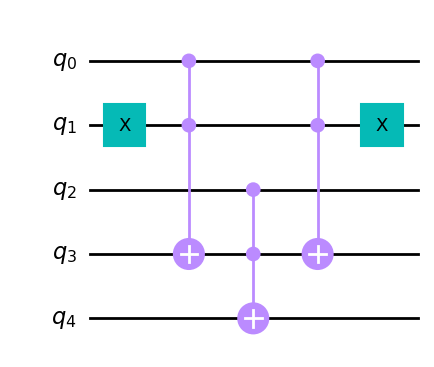

In [13]:
# reinstantiate the number of bits and the number of values being flipped
n = 5
M = 1
# calculate the optimal number of Grover iterations
iter = int(np.floor((np.pi/4)*np.sqrt(2**(n-2)/M)))

# create oracle circuit
oracle = QuantumCircuit(n, name="oracle")
oracle.x(1)
oracle.ccx(0, 1, 3)
oracle.ccx(2, 3, 4)
oracle.ccx(0, 1, 3)
oracle.x(1)

oracle.to_gate()

display(oracle.draw('mpl'))

Looking at the oracle above, we can see 3 toffoli gates, 3 qubits for the input, an auxillary qubit, and the output qubit. The X gates are going to define the value that this oracle is searching for. Without any X gates, this oracle would be looking for the 111 state, but with the not gates covering the outside of the q1 qubit, this is representing a 0 value. The value we are looking for is 101, in this case. 

If you are struggling with the logic of the Toffoli gates, think of it like these logical statements that are simialar to code:  
**if q₀ == 1 and q₁ == 1:**
- flip the value of q₃ (in this case it will be flipping it to 1) 
- *q₃ now represents whether q₀ and q₁ are both equal to 1*  

**if q₂ == 1 and q₃ == 1:**
- flip the value of q₄ (in this case the value is already set to $|-\rangle$)  
- *now that we have confirmed that q₀, q₁, and q₂ are all equal to 1, we need to transfer the phase kickback to the qubits*  
- *q₀ and q₁ which is why we have another Toffoli gate. These values are already known to be the value 1, so this change*
- *swaps q₃ back to 0 and transfers the negative phase to the qubits.*

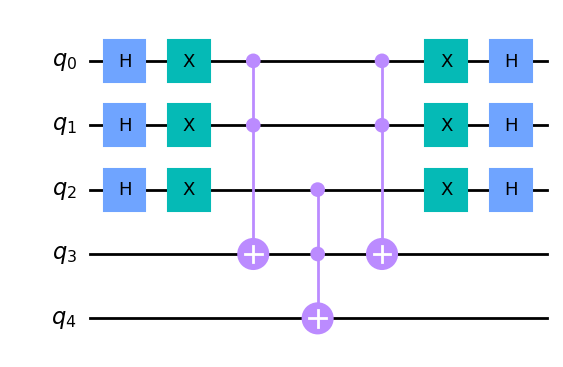

In [14]:
# create diffuser circuit
diffuser = QuantumCircuit(n, name="diffuser")

# apply h gates to reflex the states around the mean
diffuser.h(range(n-2))
diffuser.x(range(n-2))
diffuser.ccx(0, 1, 3)
diffuser.ccx(2, 3, 4)
diffuser.ccx(0, 1, 3)
# return the states to their original form for the next pass
diffuser.x(range(n-2))
diffuser.h(range(n-2))

diffuser.to_gate()

display(diffuser.draw('mpl'))

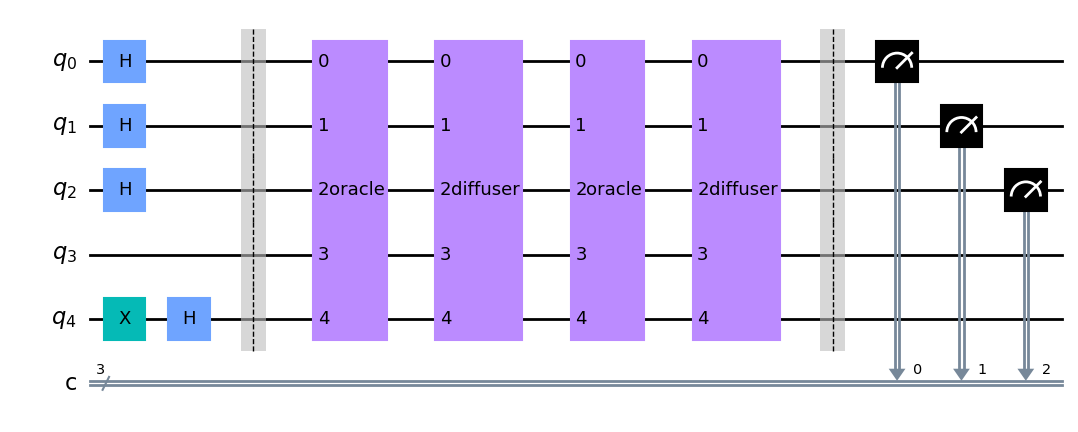

In [15]:
# create the grover search algorithm circuit
grover = QuantumCircuit(n, n-2)

grover.data = []

# set q₄ to state |->
grover.x(n-1)
grover.h(n-1)
# set q₀-q₂ to |+> 
grover.h(range(n-2))
# set q₃ to |0>
grover.barrier()

# loop through the grover operations for the previously defined number of iterations
for i in range(iter):
    grover.append(oracle, range(n))
    grover.append(diffuser, range(n))

grover.barrier()
grover.measure(range(n-2), range(n-2))

display(grover.draw('mpl'))

{'101': 967, '000': 11, '110': 5, '100': 13, '010': 12, '001': 8, '111': 3, '011': 5}


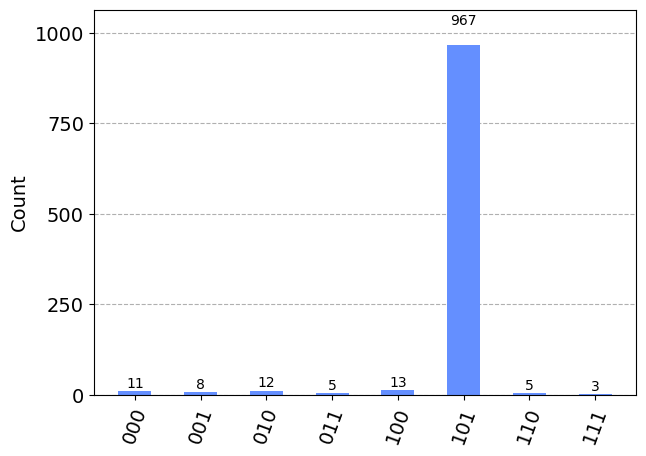

In [16]:
# simulate algorithm circuit
compiled = transpile(grover, sim)
job = assemble(compiled)

result = sim.run(compiled).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

And there we go, through 2 iterations of Grovers Search Algorithm, we were able to product 95% accuracy from a single shot. Keep in mind that Grovers Search Algorithm is not stuck to this implementation. There are a plethora of different styles, variations, with their own reasonings. There are an incredible number of applications for this algorithm and a lot more to discover about it as our quantum computers improve.